📥 Fetching data from Yahoo Finance...
📈 Fetching AAPL.NAS (AAPL)...
YF.download() has changed argument auto_adjust default to True
📈 Fetching AAVEUSD (AAVE-USD)...
📈 Fetching ABBV.NYSE (ABBV)...
📈 Fetching ABNB.NAS (ABNB)...
📈 Fetching ABT.NYSE (ABT)...
📈 Fetching ACN.NYSE (ACN)...
📈 Fetching ADAUSD (ADA-USD)...
📈 Fetching ADBE.NAS (ADBE)...
📈 Fetching ADS.XE (ADS.DE)...
📈 Fetching AI.EPA (AI.PA)...
📈 Fetching AIR.EPA (AIR.PA)...
📈 Fetching ALGOUSD (ALGO-USD)...
📈 Fetching ALV.XE (ALV.DE)...
📈 Fetching AMD.NAS (AMD)...
📈 Fetching AMZN.NAS (AMZN)...
📈 Fetching APTUSD (APT21794-USD)...
📈 Fetching ASML.EAS (ASML.AS)...
📈 Fetching ATOMUSD (ATOM-USD)...
📈 Fetching AUDCAD (AUDCAD=X)...
📈 Fetching AUDCHF (AUDCHF=X)...
📈 Fetching AUDJPY (AUDJPY=X)...
📈 Fetching AUDNZD (AUDNZD=X)...
📈 Fetching AUDUSD (AUDUSD=X)...
📈 Fetching AUS200 (^AXJO)...
📈 Fetching AVAXUSD (AVAX-USD)...
📈 Fetching AVGO.NAS (AVGO)...
📈 Fetching AXP.NYSE (AXP)...
📈 Fetching AXSUSD (AXS-USD)...
📈 Fetching AZN.LSE (AZN.L)...
📈


1 Failed download:
['INTU']: Timeout('Failed to perform, curl: (28) Operation timed out after 10014 milliseconds with 181997 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


📈 Fetching IOTAUSD (IOTA-USD)...
📈 Fetching ISP.MIL (ISP.MI)...
📈 Fetching ISRG.NAS (ISRG)...
📈 Fetching ITX.BM (ITX.MC)...
📈 Fetching JAR.SGX (C07.SI)...
📈 Fetching JD.NAS (JD)...
📈 Fetching JNJ.NYSE (JNJ)...
📈 Fetching JPM.NYSE (JPM)...
📈 Fetching JPN225 (^N225)...
📈 Fetching KEE.TSE (6861.T)...
📈 Fetching KO.NYSE (KO)...
📈 Fetching LI.NAS (LI)...
📈 Fetching LIN.NYSE (LIN)...
📈 Fetching LINKUSD (LINK-USD)...
📈 Fetching LLY.NYSE (LLY)...
📈 Fetching LMT.NYSE (LMT)...
📈 Fetching LRCUSD (LRC-USD)...
📈 Fetching LSEG.LSE (LSEG.L)...
📈 Fetching LTCUSD (LTC-USD)...
📈 Fetching MA.NYSE (MA)...
📈 Fetching MANAUSD (MANA-USD)...
📈 Fetching MBG.XE (MBG.DE)...
📈 Fetching MC.EPA (MC.PA)...
📈 Fetching MCD.NYSE (MCD)...
📈 Fetching MDLZ.NAS (MDLZ)...
📈 Fetching META.NAS (META)...
📈 Fetching MMM.NYSE (MMM)...
📈 Fetching MRK.NYSE (MRK)...
📈 Fetching MRK.XE (MRK.DE)...
📈 Fetching MS.NYSE (MS)...
📈 Fetching MSFT.NAS (MSFT)...
📈 Fetching MUR.TSE (6981.T)...
📈 Fetching NAB.ASX (NAB.AX)...
📈 Fetching NAS100 (

c:\Users\syahr\Desktop\Portfolio\Trading\analyzer.py:198: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_chg = round(df["Close"].pct_change().abs().mean(), 7)



📊 Analyzing TMO.NYSE...

📊 Analyzing TMUS.NAS...

📊 Analyzing TRXUSD...

📊 Analyzing TSLA.NAS...

📊 Analyzing TTE.EPA...

📊 Analyzing TXN.NAS...

📊 Analyzing UCG.MIL...


c:\Users\syahr\Desktop\Portfolio\Trading\analyzer.py:198: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_chg = round(df["Close"].pct_change().abs().mean(), 7)



📊 Analyzing UK100...

📊 Analyzing UNH.NYSE...

📊 Analyzing UNIUSD...

📊 Analyzing UNP.NYSE...

📊 Analyzing UPS.NYSE...

📊 Analyzing US30...

📊 Analyzing USDCAD...

📊 Analyzing USDCHF...

📊 Analyzing USDJPY...

📊 Analyzing USDMXN...

📊 Analyzing USDZAR...

📊 Analyzing V.NYSE...

📊 Analyzing VNA.XE...

📊 Analyzing VOW3.XE...

📊 Analyzing VZ.NYSE...

📊 Analyzing WES.ASX...

📊 Analyzing WFC.NYSE...

📊 Analyzing WMT.NYSE...

📊 Analyzing XAGUSD...

📊 Analyzing XAUUSD...

📊 Analyzing XBRUSD...

📊 Analyzing XNGUSD...

📊 Analyzing XOM.NYSE...

📊 Analyzing XRPUSD...

📊 Analyzing XTIUSD...


c:\Users\syahr\Desktop\Portfolio\Trading\analyzer.py:198: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_chg = round(df["Close"].pct_change().abs().mean(), 7)



📊 Analyzing ZECUSD...


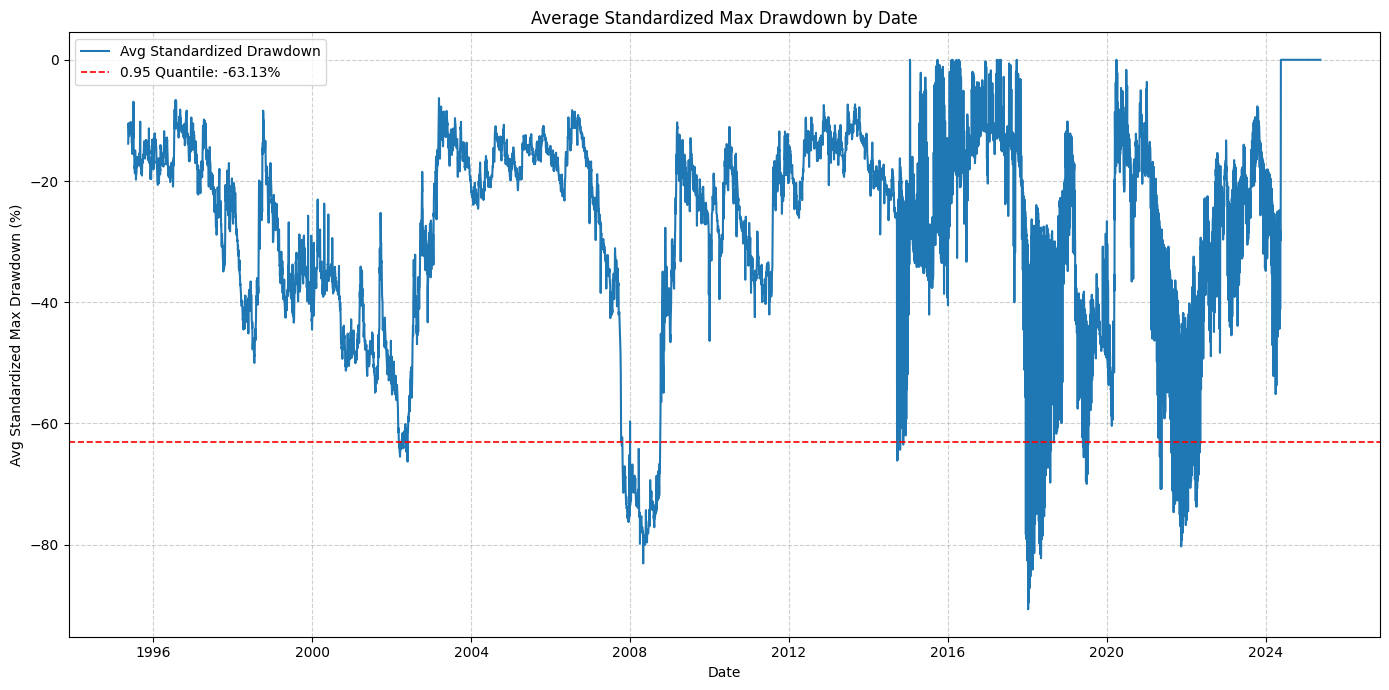

🔄 Fetching MT5 live prices...
✅ AAPL.NAS: updated MT5 Price = 210.76, Min = 196.45, Max = 241.82
✅ AAVEUSD: updated MT5 Price = 233.57, Min = 93.97, Max = 310.58
✅ ABBV.NYSE: updated MT5 Price = 182.16, Min = 162.13, Max = 200.18
✅ ABNB.NAS: updated MT5 Price = 137.42, Min = 115.72, Max = 147.13
✅ ABT.NYSE: updated MT5 Price = 134.11, Min = 101.45, Max = 130.85
✅ ACN.NYSE: updated MT5 Price = 315.35, Min = 287.23, Max = 364.48
✅ ADAUSD: updated MT5 Price = 0.7746, Min = 0.3449, Max = 0.9965
✅ ADBE.NAS: updated MT5 Price = 414.22, Min = 381.67, Max = 557.09
✅ ADS.XE: updated MT5 Price = 218.871, Min = 210.963, Max = 243.251
✅ AI.EPA: updated MT5 Price = 186.53, Min = 159.16, Max = 178.40
✅ AIR.EPA: updated MT5 Price = 160.11, Min = 129.87, Max = 165.72
✅ ALGOUSD: updated MT5 Price = 0.2245, Min = 0.1203, Max = 0.3846
✅ ALV.XE: updated MT5 Price = 350.17, Min = 258.94, Max = 350.57
✅ AMD.NAS: updated MT5 Price = 117.40, Min = 99.22, Max = 165.85
✅ AMZN.NAS: updated MT5 Price = 205.54, Mi

In [1]:
import os
import yaml
from data_fetcher import YahooFinanceDataFetcher
from mt5_fetcher import MT5DataFetcher
from google_sheet_api import GoogleSheetsUploader
from analyzer import run_analysis, run_all_analyses

# === Setup Paths === #
BASE_DIR = os.getcwd()
CONFIG_PATH = os.path.join(BASE_DIR, "config.yaml")
CREDENTIAL_PATH = os.path.join(BASE_DIR, "credential_google_sheets.json")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# === Load Configuration === #
def load_config(path):
    with open(path, "r") as file:
        return yaml.safe_load(file)

config = load_config(CONFIG_PATH)

# === Extract Parameters with Defaults === #
fetch_mt5 = config.get("fetch_mt5", True)
params = {
    "std_multiplier": config.get("std_multiplier", 1.96),
    "initial_balance": config.get("initial_balance", 1000),
    "invest_per_week": config.get("invest_per_week", 100),
    "leverage": config.get("leverage", 1000),
    "min_years_required": config.get("min_years_required", 1)
}

def main():
    print("📥 Fetching data from Yahoo Finance...")
    fetcher = YahooFinanceDataFetcher(CONFIG_PATH)
    full_df = fetcher.get_data()
    symbol_list = full_df["Symbol"].unique()

    # Run analysis for one example symbol
    symbol = "GOOGL.NAS"
    df, dd_thresh, gain_thresh, daily_chg = run_analysis(
        df=full_df,
        symbol=symbol,
        plots_dir=PLOTS_DIR,
        coeff=fetcher.coeff_map.get(symbol),
        **params
    )
    
    # Run all symbol analyses
    df_summary, df_final = run_all_analyses(
        full_df=full_df,
        symbol_list=symbol_list,
        plots_dir=PLOTS_DIR,
        coeff_map=fetcher.coeff_map,
        **params
    )

    # Optionally fetch live prices from MT5
    if fetch_mt5:
        print("🔄 Fetching MT5 live prices...")
        df = MT5DataFetcher(df_summary, params["min_years_required"])

    # Upload results to Google Sheets
    try:
        print("📤 Uploading to Google Sheets...")
        uploader = GoogleSheetsUploader(CREDENTIAL_PATH, "Financial Report - Indonesia")
        uploader.upload_dataframe(df, "Overview", replace=False)
        print("✅ Upload successful!")
    except Exception as e:
        print(f"❌ Upload failed: {e}")

if __name__ == "__main__":
    main()

In [2]:
# === Imports === #
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import yaml
import os
from google_sheet_api import GoogleSheetsUploader

# === Setup Paths === #
BASE_DIR = os.getcwd()
CONFIG_PATH = os.path.join(BASE_DIR, "config.yaml")
CREDENTIAL_PATH = os.path.join(BASE_DIR, "credential_google_sheets.json")

# === Load Configuration === #
def load_config(path):
    """Load configuration from YAML file."""
    with open(path, "r") as file:
        return yaml.safe_load(file)

config = load_config(CONFIG_PATH)

# === Initialize MT5 Connection === #
if not mt5.initialize():
    print("MT5 initialization failed.")
    quit()

# === Retrieve Account Information === #
account_info = mt5.account_info()
if account_info is None:
    print("Failed to retrieve account information.")
    mt5.shutdown()
    quit()

# === Extract Balance, Equity, and Floating Loss === #
balance = account_info.balance
equity = account_info.equity
floating_loss = account_info.profit

# === Display Results === #
print("=== Account Information ===")
print(f"Balance: {balance:.2f} USD")
print(f"Equity: {equity:.2f} USD")
print(f"Floating Loss: {floating_loss:.2f} USD")

# === Fetch and Process Running Trades === #
fetcher = GoogleSheetsUploader(CREDENTIAL_PATH, "Financial Report - Indonesia")
df = fetcher.get_sheet_as_dataframe("Forex")
positions = mt5.positions_get()
df_positions = pd.DataFrame([pos._asdict() for pos in positions]) if positions else pd.DataFrame()

if df_positions.empty:
    print("No running trades found. Error:", mt5.last_error())
else:
    # Filter and rename columns
    df_positions = df_positions[["type", "volume", "price_open", "price_current", "sl", "tp", "profit", "symbol"]]
    df_positions["type"] = df_positions["type"].replace({0: "Buy", 1: "Sell"})
    df_positions.rename(columns={
        "symbol": "Symbol",
        "type": "Action",
        "volume": "Lot",
        "price_open": "Price",
        "price_current": "Price Current",
        "sl": "SL",
        "tp": "TP",
        "profit": "Profit"
    }, inplace=True)

    # Aggregate by Symbol and Action
    def aggregate_group(group):
        symbol = group["Symbol"].iloc[0]
        action = group["Action"].iloc[0]
        lot = group["Lot"].sum()
        warnings = []

        # === Lot mismatch check === #
        df_lot_value = df.loc[(df.iloc[:, 0] == symbol) & (df.iloc[:, 2] == action), df.columns[5]].sum()
        if not pd.isna(df_lot_value) and round(df_lot_value, 2) > round(lot, 2):
            warnings.append(f"Lot Mismatch: Expected {round(df_lot_value, 2)}, Found {round(lot, 2)}")

        # === SL/TP mismatch check === #
        df_sl_value = df.loc[(df.iloc[:, 0] == symbol) & (df.iloc[:, 2] == action), df.columns[7]].sum()
        sl_mode = group["SL"].mode().iloc[0] if not group["SL"].mode().empty else np.nan
        if group["SL"].nunique() > 1 or (df_sl_value != 0 and round(df_sl_value, 2) != round(sl_mode, 2)):
            warnings.append("SL Mismatch")

        df_tp_value = df.loc[(df.iloc[:, 0] == symbol) & (df.iloc[:, 2] == action), df.columns[8]].sum()
        tp_mode = group["TP"].mode().iloc[0] if not group["TP"].mode().empty else np.nan
        if group["TP"].nunique() > 1 or round(df_tp_value, 2) != round(tp_mode, 2):
            warnings.append("TP Mismatch")

        # Combine warnings
        warning_message = "; ".join(warnings) if warnings else np.nan

        return pd.Series({
            "Lot": lot,
            "Price": (group["Price"] * group["Lot"]).sum() / group["Lot"].sum(),
            "Price Current": group["Price Current"].mean(),
            "SL": group["SL"].mode().iloc[0] if not group["SL"].empty else np.nan,
            "TP": group["TP"].mode().iloc[0] if not group["TP"].empty else np.nan,
            "Profit": group["Profit"].sum(),
            "Warning": warning_message
        })

    df_positions = (
        df_positions.groupby(["Symbol", "Action"], as_index=False)
        .apply(lambda group: aggregate_group(group))
        .reset_index(drop=True)
    )

# === Shutdown MT5 Connection === #
mt5.shutdown()

# === Calculate Coefficients === #
df_positions["Coeff"] = np.abs(df_positions["Profit"] / (df_positions["Price Current"] - df_positions["Price"])) / (df_positions["Lot"] * 100)
df_positions["Pips"] = np.abs(df_positions["TP"] - df_positions["SL"])

# Merging the Type column based on Symbol
df_type = df[[df.columns[0], df.columns[1]]].drop_duplicates()
df_type.columns = ["Symbol", "Type"]
df_positions = pd.merge(df_positions, df_type, on="Symbol", how="left")

# Handling missing types (optional)
df_positions['Type'].fillna("Unknown", inplace=True)

df_positions

# === Update Coefficients in Config (Exclude NaN) === #
df_avg_coeff = df_positions.groupby("Symbol")["Coeff"].mean().reset_index()
differences = {}

for _, row in df_avg_coeff.iterrows():
    symbol = row["Symbol"]
    avg_coeff = round(row["Coeff"], 5)
    
    # Only update if coefficient is not NaN
    if not pd.isna(avg_coeff):
        if symbol in config.get("symbol_coefficients", {}):
            old_coeff = config["symbol_coefficients"].get(symbol, avg_coeff)
            if old_coeff != avg_coeff:
                differences[symbol] = {"Old": old_coeff, "New": avg_coeff}
        
        # Add or update the coefficient
        config["symbol_coefficients"][symbol] = avg_coeff

# === Save Updated Configuration === #
with open(CONFIG_PATH, "w") as file:
    yaml.safe_dump(config, file)

# === Display Changed Coefficients === #
print("Changed symbol_coefficients:")
for symbol, change in differences.items():
    print(f"{symbol}: {change['Old']} -> {change['New']}")

# Creating new rows for Balance, Equity, and Floating Loss
df_balance = pd.DataFrame([
    {"Symbol": "Balance", "Price": balance},
    {"Symbol": "Equity", "Price": equity},
    {"Symbol": "Floating Loss", "Price": floating_loss}
])

# Inserting the new rows at the top of the DataFrame
df_final = pd.concat([df_balance, df_positions], ignore_index=True)

# === Uploade Updated Dataframe === #
uploader = GoogleSheetsUploader(CREDENTIAL_PATH, "Financial Report - Indonesia")
uploader.upload_dataframe(df_final, "Forex Summary", replace=True)

# === Display Final Merged DataFrame === #
print("Final Merged DataFrame:")
df_final

import time
import MetaTrader5 as mt5
import pandas as pd
import os
from google_sheet_api import GoogleSheetsUploader

# === Setup Paths === #
BASE_DIR = os.getcwd()
CONFIG_PATH = os.path.join(BASE_DIR, "config.yaml")
CREDENTIAL_PATH = os.path.join(BASE_DIR, "credential_google_sheets.json")

# === Initialize MT5 Connection === #
if not mt5.initialize():
    print("MT5 initialization failed.")
    quit()

fetcher = GoogleSheetsUploader(CREDENTIAL_PATH, "Financial Report - Indonesia")

# Load DataFrame from Google Sheets
df = fetcher.get_sheet_as_dataframe("Forex")
df.columns = df.iloc[6]
df = df.iloc[7:-3].reset_index(drop=True)

# Initialize counters for success and failure
success_count = 0
failure_count = 0

# Fetch unique symbols from running trades in MT5
positions = mt5.positions_get()
if positions is None or len(positions) == 0:
    print("No running trades found. Exiting.")
    mt5.shutdown()
    quit()

# Get unique symbols from MT5 positions
symbol_list = sorted(list(set(pos.symbol for pos in positions)))

# Convert positions to DataFrame for easy filtering
df_positions = pd.DataFrame([pos._asdict() for pos in positions])

# Iterate through each unique symbol from MT5 positions
for symbol in symbol_list:
    print(f"\n=== Checking Symbol: {symbol} ===")
    for action in ["Buy", "Sell"]:
        print(f"  Action: {action}")
        action_type = 0 if action == "Buy" else 1
        filtered_positions = df_positions[(df_positions['symbol'] == symbol) & (df_positions['type'] == action_type)]
        
        if filtered_positions.empty:
            print(f"    ⚠️ No {action} positions running. Skipping.")
            continue

        # Filter rows for the current symbol and action from Google Sheets
        df_filtered = df[(df["Symbol"] == symbol) & (df["Action"] == action)]
        
        if df_filtered.empty:
            print(f"    ⚠️ No matching TP/SL settings in Google Sheets.")
            continue
        
        tp_value = df_filtered['TP'].values[0]
        sl_value = df_filtered['SL'].values[0]

        # Iterate over filtered positions for modification
        for _, pos in filtered_positions.iterrows():
            order_id = pos['ticket']
            current_tp = pos['tp']
            current_sl = pos['sl']

            # Check for differences and print
            print(f"    Position ID: {order_id}")
            print(f"    Current TP: {current_tp}, Current SL: {current_sl}")
            print(f"    Target TP: {tp_value}, Target SL: {sl_value}")

            if current_tp == tp_value and current_sl == sl_value:
                print(f"    ✅ No changes needed for {action} position {order_id}.")
                continue
            else:
                print(f"    ⚠️ TP/SL difference detected. Attempting to update...")

            # Modify TP/SL using position ID
            request = {
                "action": mt5.TRADE_ACTION_SLTP,
                "position": order_id,
                "sl": sl_value,
                "tp": tp_value
            }

            # Send modification request
            result = mt5.order_send(request)

            # Check if result is None (Error)
            if result is None:
                print(f"    ⚠️ Failed to modify {action} position {order_id}. Error: Request returned None.")
                failure_count += 1
                continue

            # Check if the modification was successful
            if result.retcode == mt5.TRADE_RETCODE_DONE:
                print(f"    ✅ {action} position {order_id} modified successfully.")
                print(f"    Before: TP={current_tp}, SL={current_sl}")
                print(f"    After:  TP={tp_value}, SL={sl_value}\n")
                success_count += 1
            else:
                print(f"    ⚠️ Failed to modify {action} position {order_id}. Error: {result.comment}")
                failure_count += 1

# === Shutdown MT5 Connection === #
mt5.shutdown()

# === Summary Report ===
print("\n=== TP/SL Modification Summary ===")
print(f"Total Successful Modifications: {success_count}")
print(f"Total Failed Modifications: {failure_count}")

=== Account Information ===
Balance: 4589.23 USD
Equity: 4107.03 USD
Floating Loss: -1731.08 USD
✅ Successfully retrieved data from 'Forex' as a DataFrame.


C:\Users\syahr\AppData\Local\Temp\ipykernel_15584\2414785568.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: aggregate_group(group))
C:\Users\syahr\AppData\Local\Temp\ipykernel_15584\2414785568.py:123: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operatio

Changed symbol_coefficients:
AAVEUSD: 0.5 -> 0.50048
ALGOUSD: 25.00661 -> 25.0
APTUSD: 3.00086 -> 2.9987
AUDCAD: 714.82768 -> 715.08012
AUDCHF: 1192.02226 -> 1192.0
AUDJPY: 6.8521 -> 6.85349
AUDNZD: 587.64239 -> 588.14866
AVAXUSD: 1.00029 -> 1.0003
AXSUSD: 0.50014 -> 0.5
BCHUSD: 0.09997 -> 0.10007
BNBUSD: 0.09983 -> 0.10013
CADCHF: 1192.01229 -> 1192.59259
CADJPY: 6.85588 -> 6.85454
CHFJPY: 6.85257 -> 6.85604
DKI.TSE: 0.00686 -> 0.00685
DOTUSD: 2.50186 -> 2.50187
ETCUSD: 2.50156 -> 2.50314
EURAUD: 639.92499 -> 640.59655
EURCAD: 714.75171 -> 715.01768
EURCHF: 1192.69777 -> 1192.2366
EURGBP: 1327.41833 -> 1327.74406
EURJPY: 6.85117 -> 6.85879
EURMXN: 51.31429 -> 51.34981
EURNZD: 587.53301 -> 588.22907
EURZAR: 55.37789 -> 55.42256
FILUSD: 1.00247 -> 0.99987
GBPAUD: 640.03815 -> 640.6827
GBPCAD: 714.16952 -> 715.56833
GBPCHF: 1191.73554 -> 1192.20502
GBPJPY: 6.85329 -> 6.85692
GBPMXN: 51.30709 -> 51.35362
GBPNZD: 587.66108 -> 588.28061
GBPZAR: 55.37504 -> 55.42403
IOTAUSD: 50.05537 -> 50.0